In [1]:
import tensorflow as tf
from tensorflow import keras 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

DIR = 'Classification/Tensorboard'

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 5
N_BATCH =8
N_EPOCH = 130
LR = 0.0005

2024-02-02 05:46:48.228959: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 05:46:48.270815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 05:46:49.054974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset1_origin = np.load('npz/dataset1_origin.npz', allow_pickle=True)
dataset1_horizon = np.load('npz/dataset1_horizon.npz', allow_pickle=True)
dataset1_vertical = np.load('npz/dataset1_vertical.npz', allow_pickle=True)
dataset1_vh = np.load('npz/dataset1_vh.npz', allow_pickle=True)
dataset2_origin = np.load('npz/dataset2_origin.npz', allow_pickle=True)
dataset2_horizon = np.load('npz/dataset2_horizon.npz', allow_pickle=True)
dataset2_vertical = np.load('npz/dataset2_vertical.npz', allow_pickle=True)
dataset2_vh = np.load('npz/dataset2_vh.npz', allow_pickle=True)

d1o_origin_images, d1o_target_images, d1o_number_labels, d1o_coordinates = dataset1_origin['images'], dataset1_origin['filters'], dataset1_origin['numbers'],  dataset1_origin['coordinates']
d1h_origin_images, d1h_target_images, d1h_number_labels, d1h_coordinates = dataset1_horizon['images'], dataset1_horizon['filters'], dataset1_horizon['numbers'],  dataset1_horizon['coordinates']
d1v_origin_images, d1v_target_images, d1v_number_labels, d1v_coordinates = dataset1_vertical['images'], dataset1_vertical['filters'], dataset1_vertical['numbers'],  dataset1_vertical['coordinates']
d1vh_origin_images, d1vh_target_images, d1vh_number_labels, d1vh_coordinates = dataset1_vh['images'], dataset1_vh['filters'], dataset1_vh['numbers'],  dataset1_vh['coordinates']
d2o_origin_images, d2o_target_images, d2o_number_labels, d2o_coordinates = dataset2_origin['images'], dataset2_origin['filters'], dataset2_origin['numbers'],  dataset2_origin['coordinates']
d2h_origin_images, d2h_target_images, d2h_number_labels, d2h_coordinates = dataset2_horizon['images'], dataset2_horizon['filters'], dataset2_horizon['numbers'],  dataset2_horizon['coordinates']
d2v_origin_images, d2v_target_images, d2v_number_labels, d2v_coordinates = dataset2_vertical['images'], dataset2_vertical['filters'], dataset2_vertical['numbers'],  dataset2_vertical['coordinates']
d2vh_origin_images, d2vh_target_images, d2vh_number_labels, d2vh_coordinates = dataset2_vh['images'], dataset2_vh['filters'], dataset2_vh['numbers'],  dataset2_vh['coordinates']

origin_images = np.concatenate([d1o_origin_images, d2o_origin_images, d1h_origin_images, d2h_origin_images, d1v_origin_images, d2v_origin_images, d1vh_origin_images, d2vh_origin_images], axis = 0)
target_images = np.concatenate([d1o_target_images, d2o_target_images, d1h_target_images, d2h_target_images, d1v_target_images, d2v_target_images, d1vh_target_images, d2vh_target_images], axis = 0)
numbers_labels = np.concatenate([d1o_number_labels, d2o_number_labels, d1h_number_labels, d2h_number_labels, d1v_number_labels, d2v_number_labels, d1vh_number_labels, d2vh_number_labels], axis = 0)
coordinates = np.concatenate([d1o_coordinates, d2o_coordinates, d1h_coordinates, d2h_coordinates, d1v_coordinates, d2v_coordinates, d1vh_coordinates, d2vh_coordinates], axis = 0)

print(origin_images.shape)
print(target_images.shape)
print(numbers_labels.shape)
print(coordinates.shape)


(13276, 24, 32)
(13276, 24, 32)
(13276,)
(13276, 4, 8)


In [3]:
origin_images = origin_images.reshape(13276, 24, 32, 1)
target_images = target_images.reshape(13276, 24, 32, 1)
print(origin_images.shape)
print(target_images.shape)

(13276, 24, 32, 1)
(13276, 24, 32, 1)


In [4]:
def add_noise_to_edges(images, noise_factor=50, edge_width=4):
    noisy_images = images.astype(np.float64)  # uint8에서 float64로 변환

    # 이미지의 높이와 너비
    height, width = images.shape[1], images.shape[2]

    # 노이즈 생성 및 테두리에 적용
    for i in range(images.shape[0]):  # 각 이미지에 대하여
        # 상단 및 하단 가장자리
        noisy_images[i, :edge_width, :, :] += np.random.randn(edge_width, width, 1) * noise_factor
        noisy_images[i, -edge_width:, :, :] += np.random.randn(edge_width, width, 1) * noise_factor

        # 좌측 및 우측 가장자리
        noisy_images[i, :, :edge_width, :] += np.random.randn(height, edge_width, 1) * noise_factor
        noisy_images[i, :, -edge_width:, :] += np.random.randn(height, edge_width, 1) * noise_factor

    # 클리핑하여 이미지 데이터 범위 유지
    noisy_images = np.clip(noisy_images, 0, 255).astype(np.uint8)  # 결과를 uint8로 변환

    return noisy_images



def add_selective_noise(images, noise_factor=60, noise_ratio=0.1):
    noisy_images = np.copy(images).astype(np.float64)  # 이미지 복사 및 타입 변환

    # 이미지의 높이와 너비
    height, width = images.shape[1], images.shape[2]
    total_pixels = height * width

    # 각 이미지에 대해 노이즈 적용
    for img in noisy_images:
        # 노이즈가 적용될 픽셀 수와 위치 계산
        noise_pixels = int(total_pixels * noise_ratio)
        noise_indices = np.random.choice(total_pixels, noise_pixels, replace=False)

        # 노이즈 생성 및 적용
        noise = np.random.randn(*img.shape) * noise_factor
        flat_img = img.flatten()
        np.put(flat_img, noise_indices, noise.flatten()[noise_indices])
        img[:, :, :] = flat_img.reshape(height, width, -1)

    # 클리핑하여 이미지 데이터 범위 유지
    noisy_images = np.clip(noisy_images, 0, 255).astype(np.uint8)

    return noisy_images



noisy_images = add_noise_to_edges(origin_images)
noisy_images = add_selective_noise(noisy_images)
extended_images = np.concatenate([origin_images, noisy_images], axis=0)
extended_labels = np.concatenate([numbers_labels, numbers_labels], axis=0)

extended_images.shape, extended_labels.shape

((26552, 24, 32, 1), (26552,))

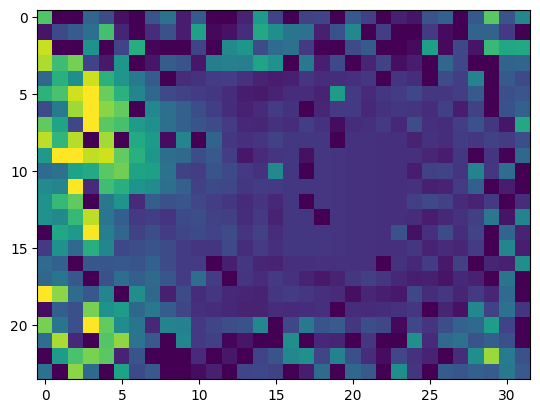

3


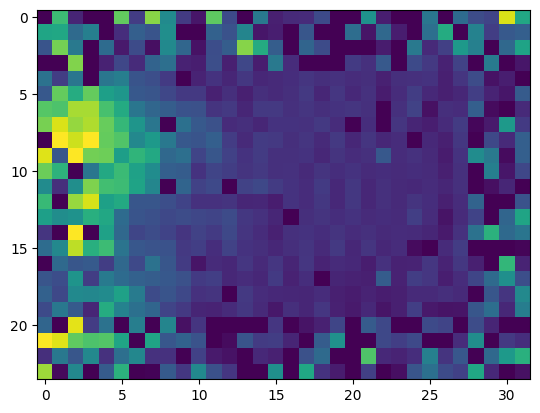

3


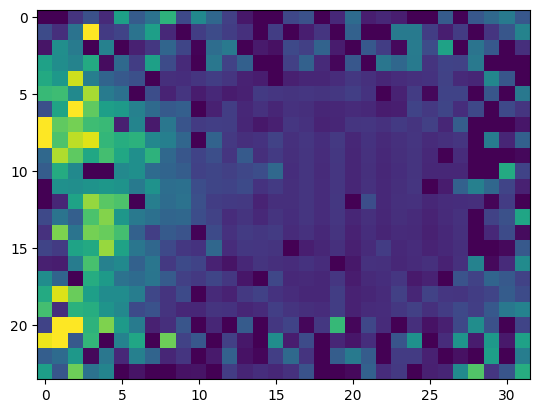

3


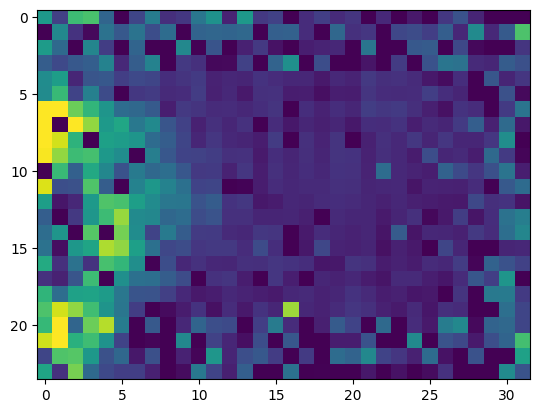

3


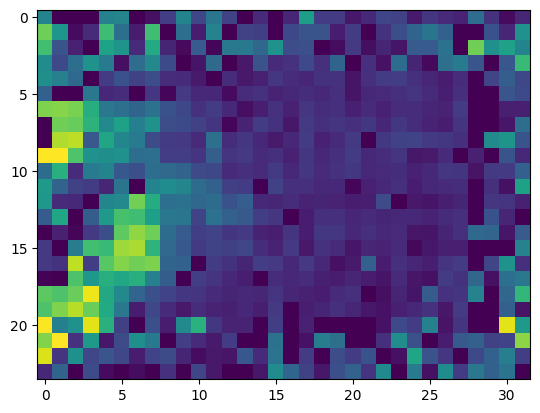

3


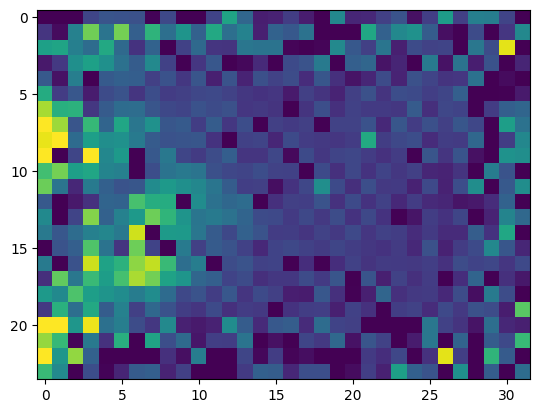

3


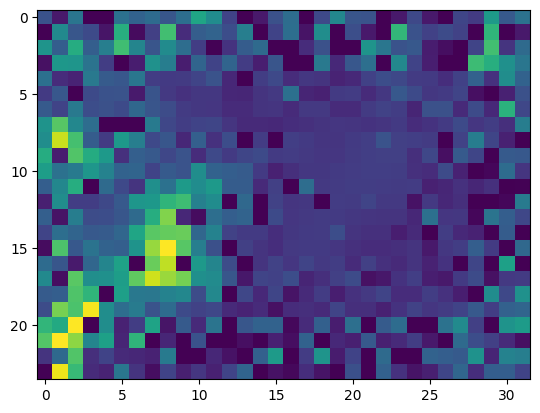

3


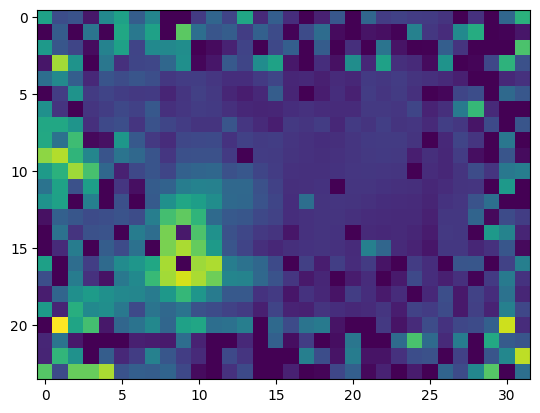

3


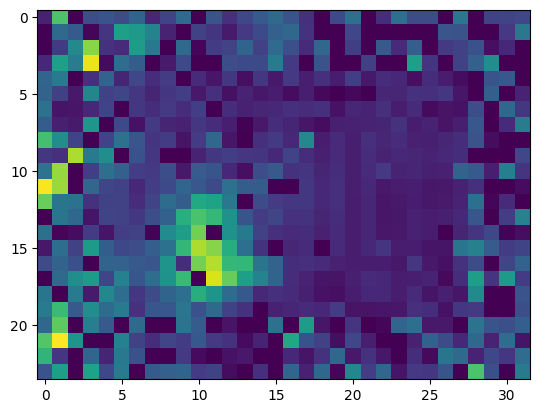

3


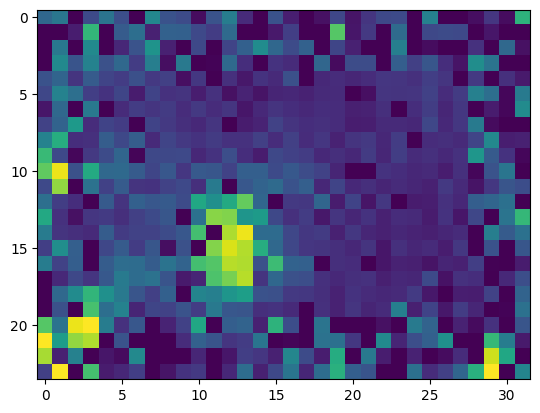

3


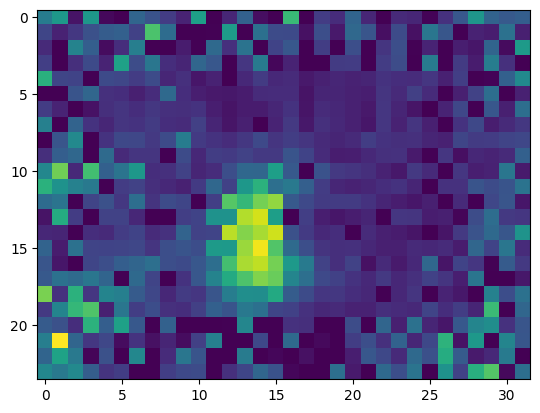

3


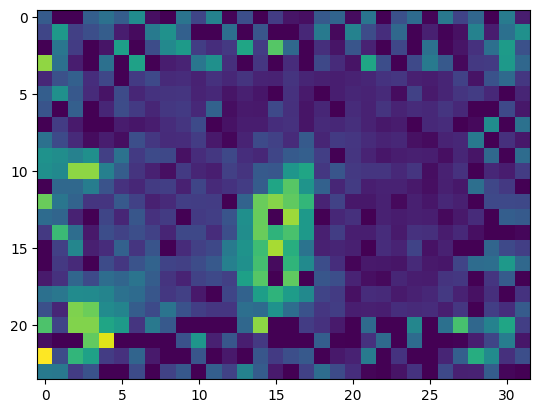

3


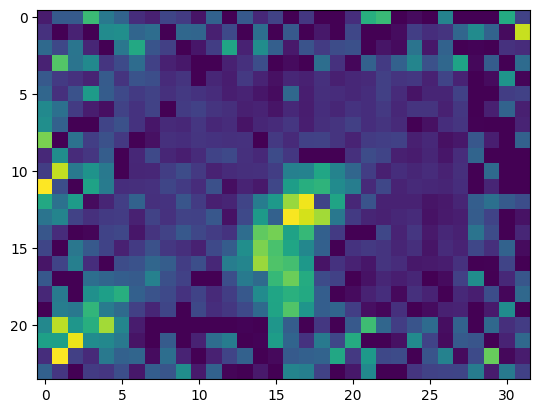

3


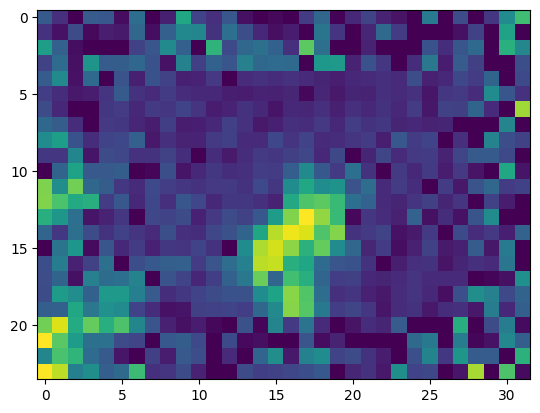

3


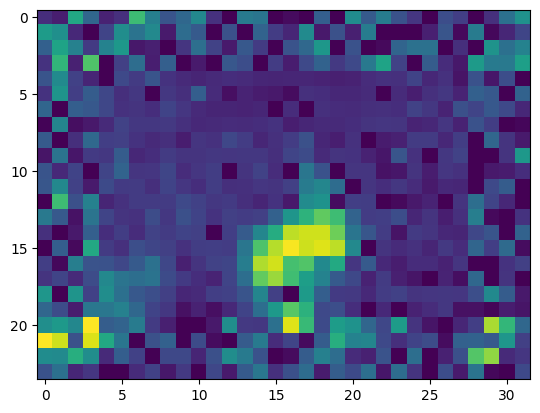

3


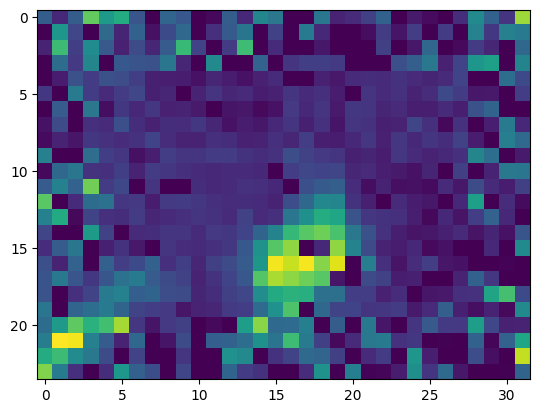

2


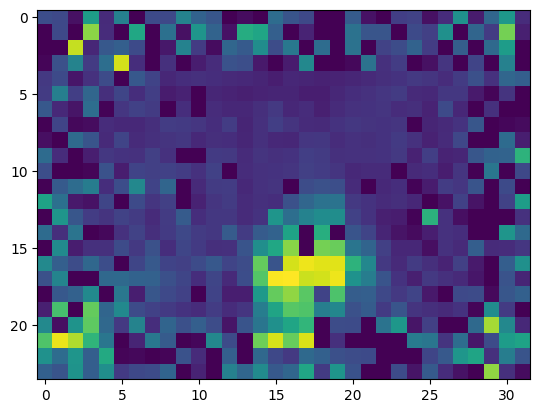

2


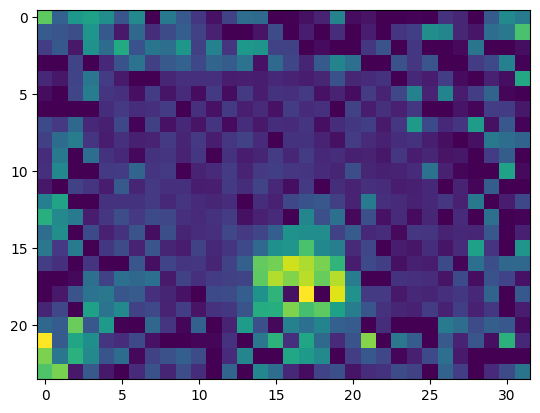

2


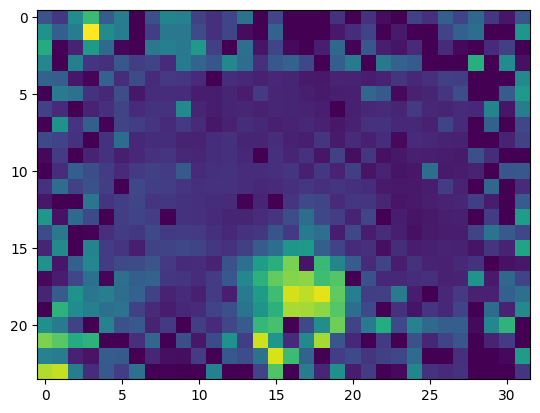

2


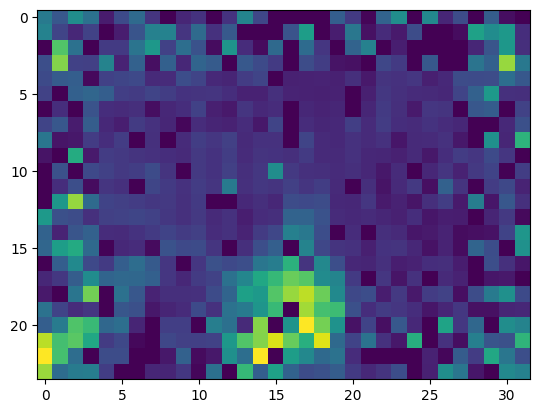

2


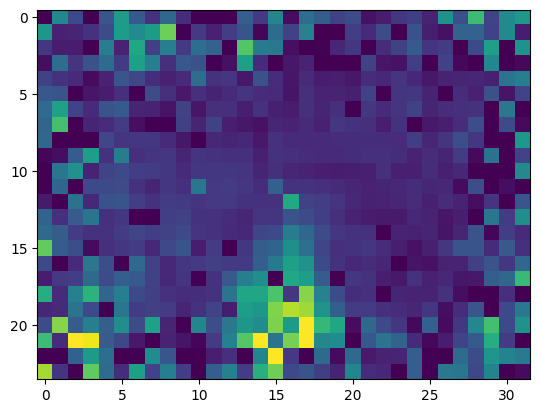

2


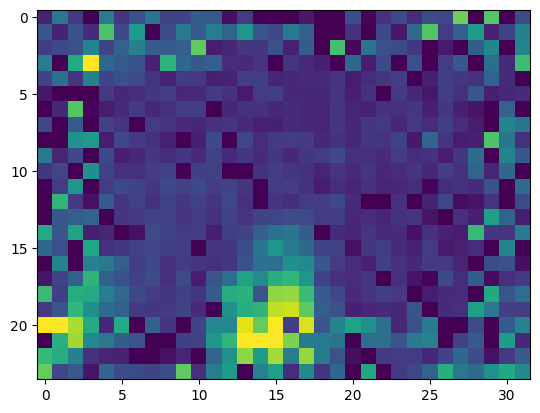

2


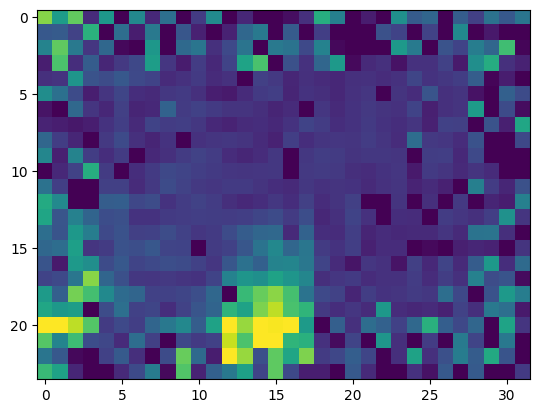

2


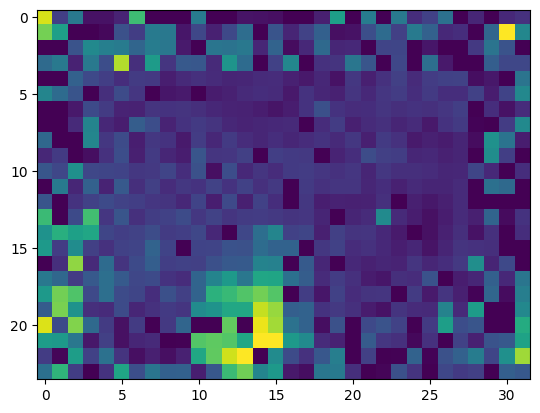

2


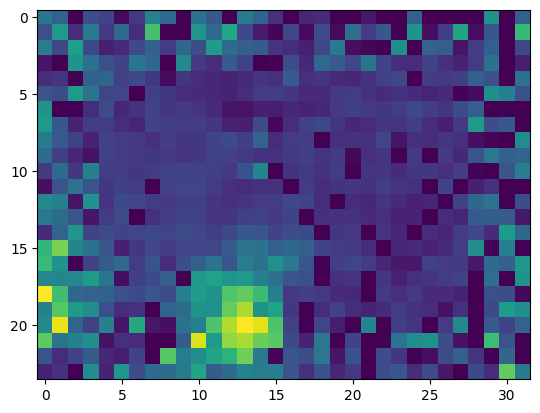

2


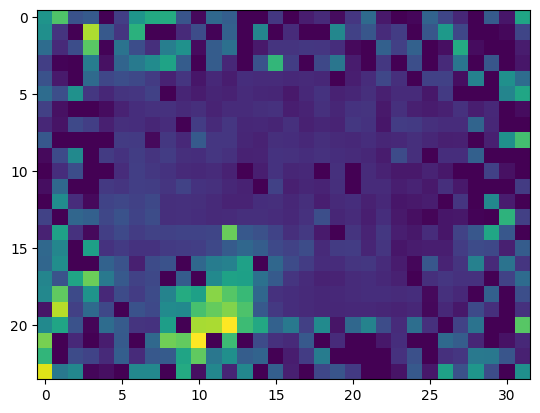

2


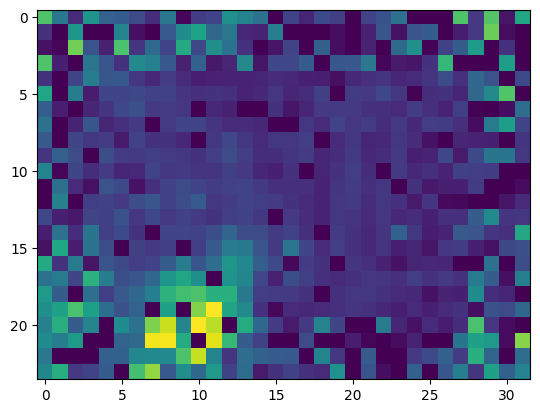

2


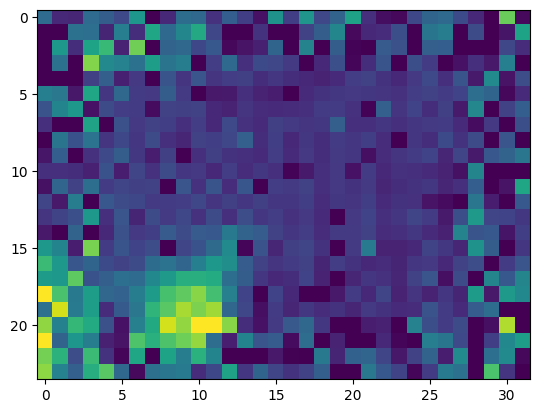

2


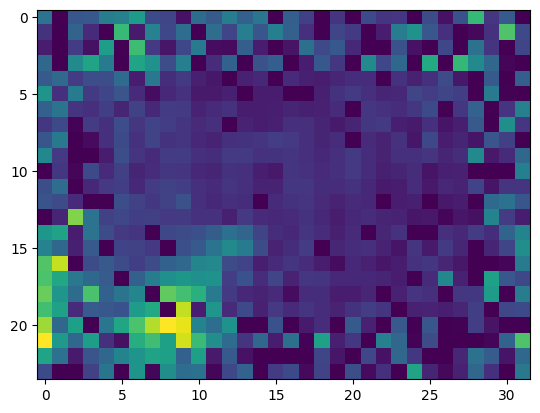

2


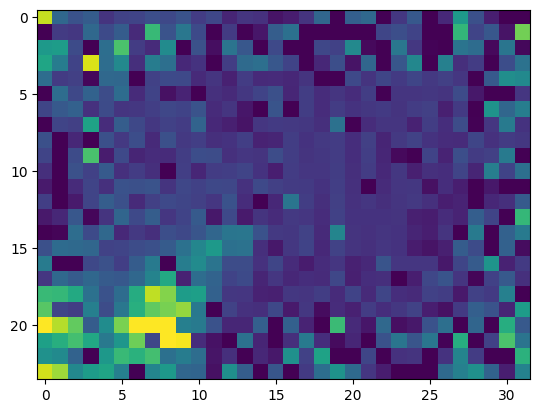

2


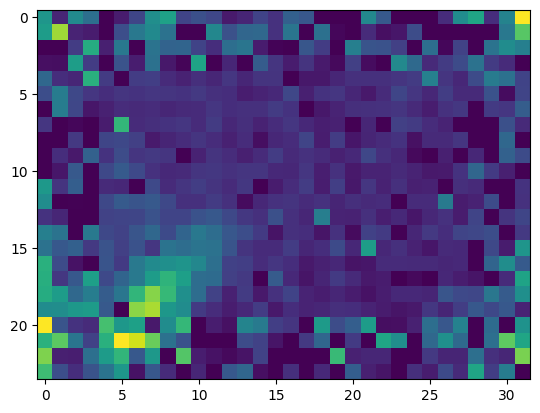

2


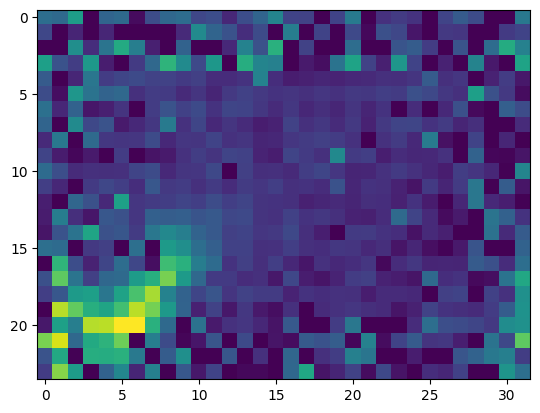

2


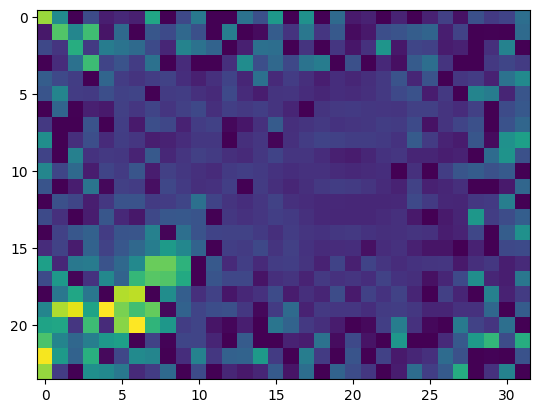

2


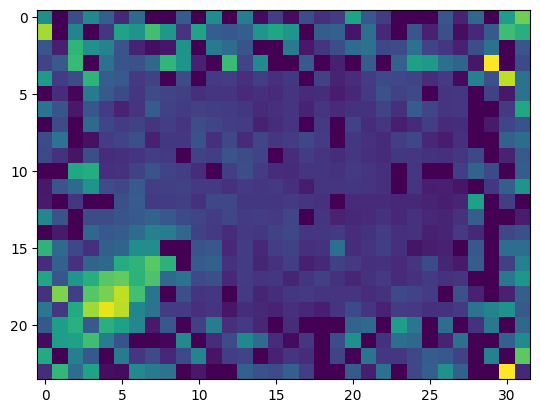

1


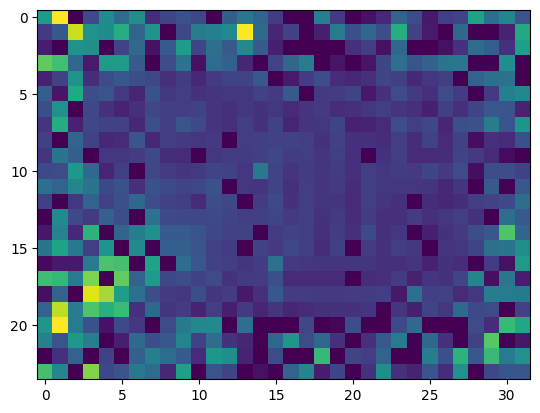

1


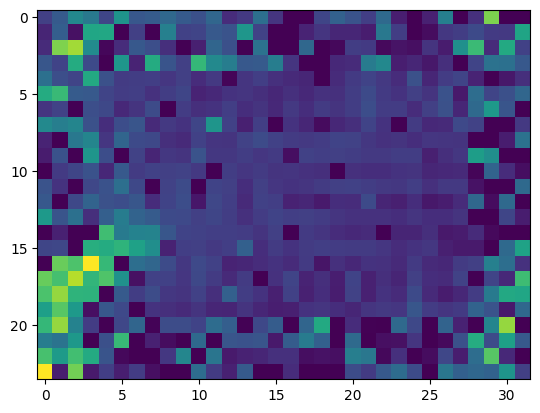

1


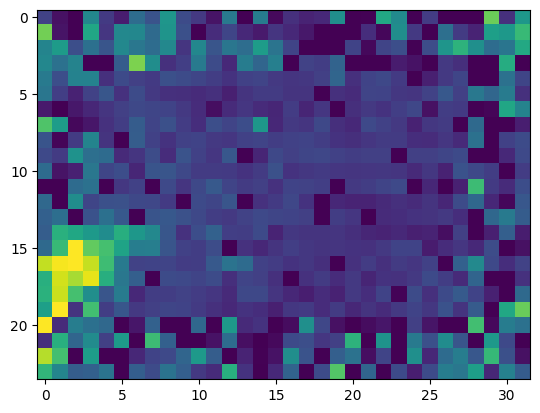

1


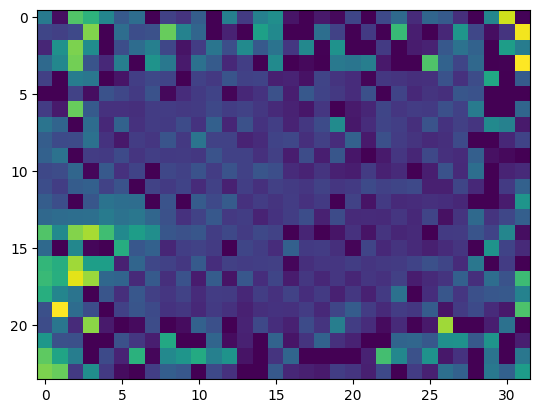

1


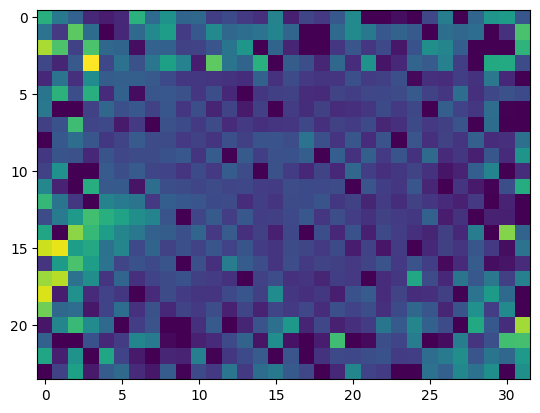

1


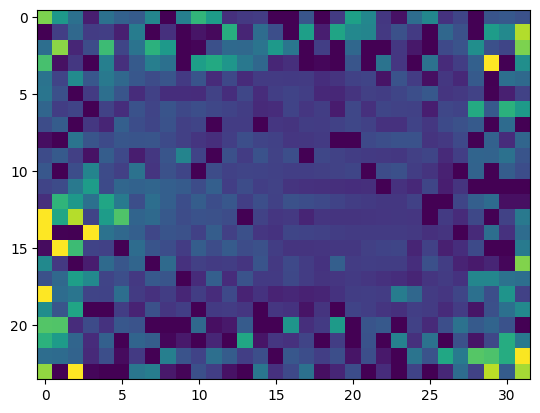

1


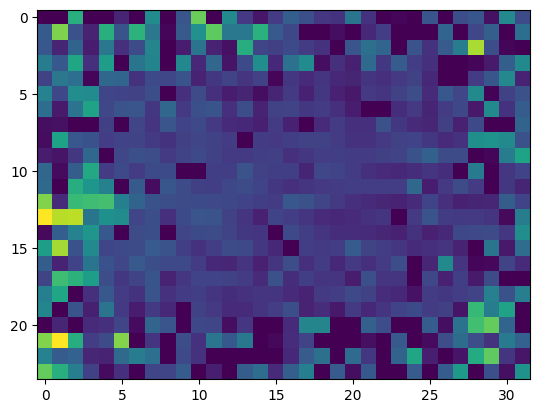

1


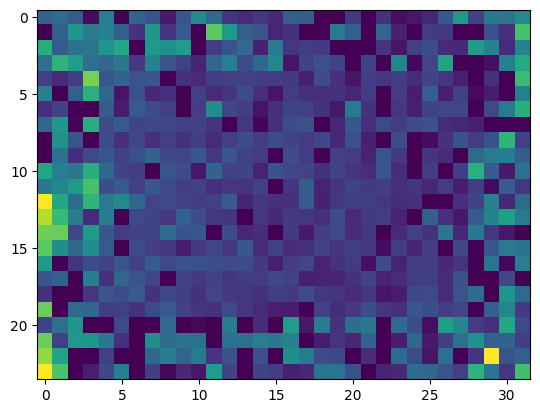

1


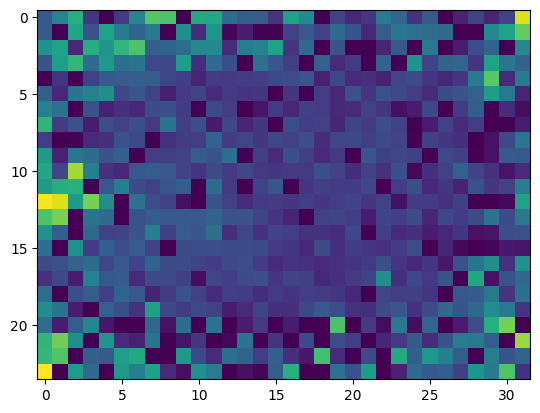

1


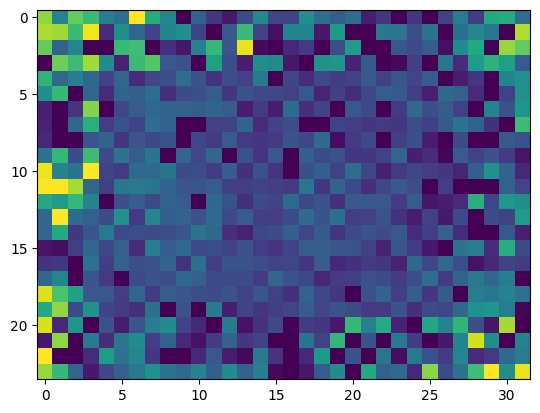

1


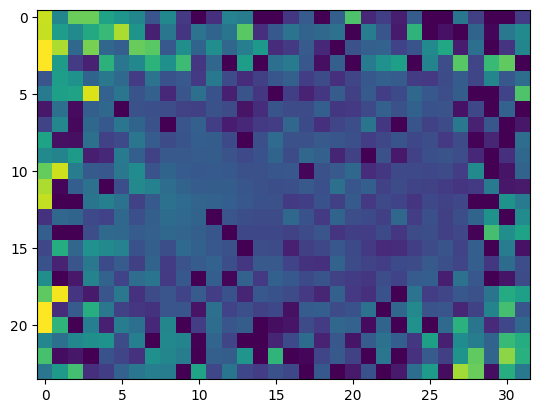

1


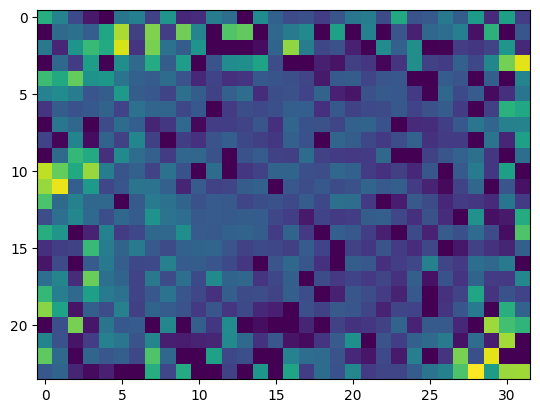

0


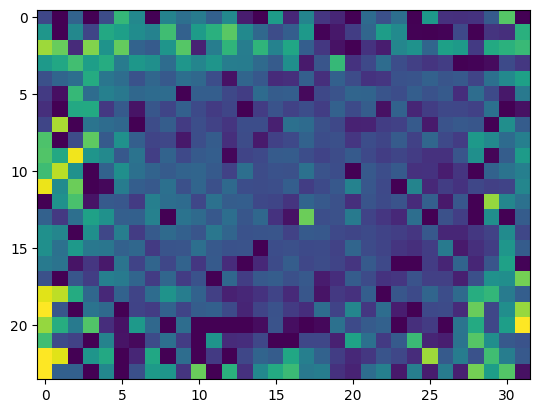

0


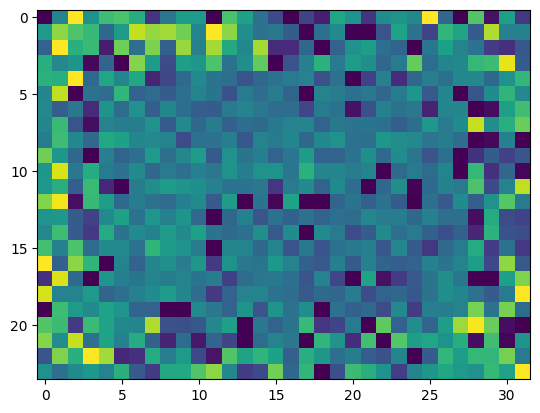

0


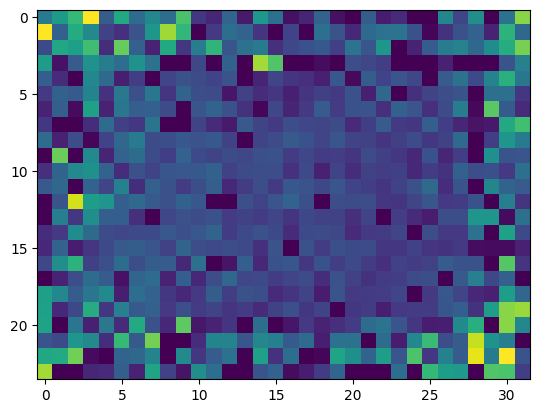

0


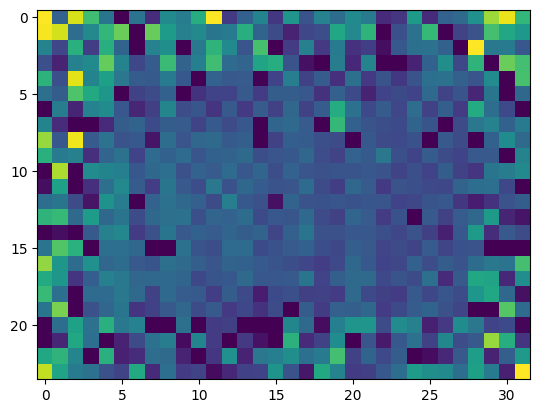

0


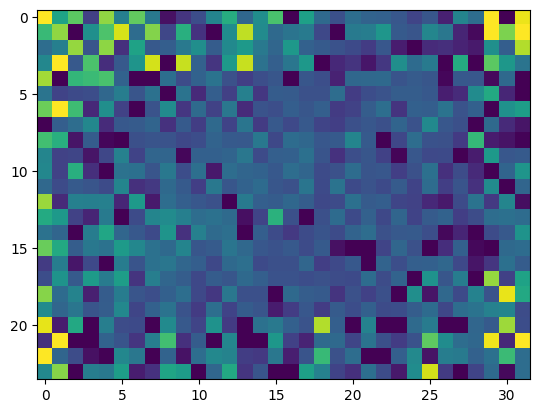

0


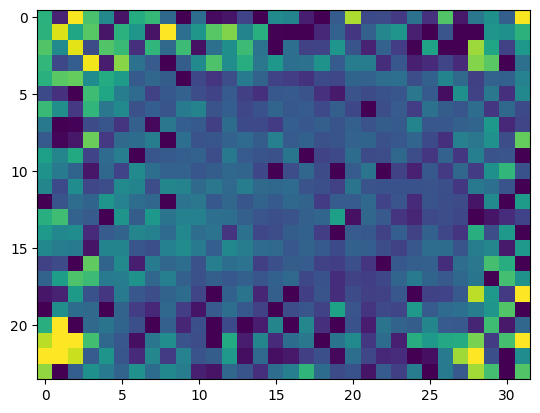

0


In [5]:
for idx in range(26500, 26552):
    plt.imshow(extended_images[idx])
    plt.show()
    print(extended_labels[idx])

In [6]:
print(extended_images.max(), extended_images.min())
# print(target_images.max(), target_images.min())

origin_images = extended_images / extended_images.max()

# target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
# print(target_images.max(), target_images.min())

print(origin_images.shape)
# print(target_images.shape)

255 0
1.0 0.0
(26552, 24, 32, 1)


In [7]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    origin_images, extended_labels, test_size=0.3, random_state=42
)

In [8]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=NUM_CLASS)
    return image, label

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

2024-02-02 05:47:07.769146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-02-02 05:47:07.771299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22292 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-02-02 05:47:07.773177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22292 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-02-02 05:47:07.774999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22292 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

In [10]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [11]:
train_ds = train_ds.shuffle(buffer_size=len(train_images)).batch(N_BATCH).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=len(val_images)).batch(N_BATCH).prefetch(buffer_size=AUTOTUNE)

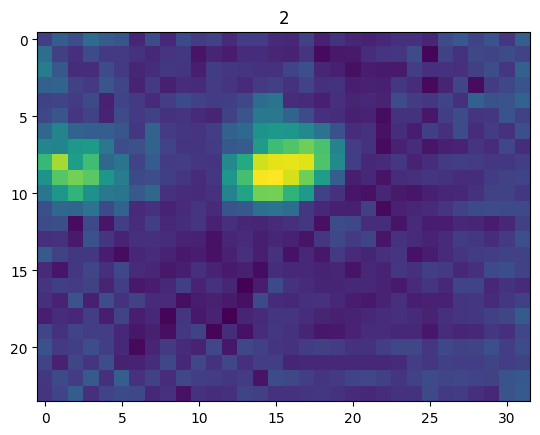

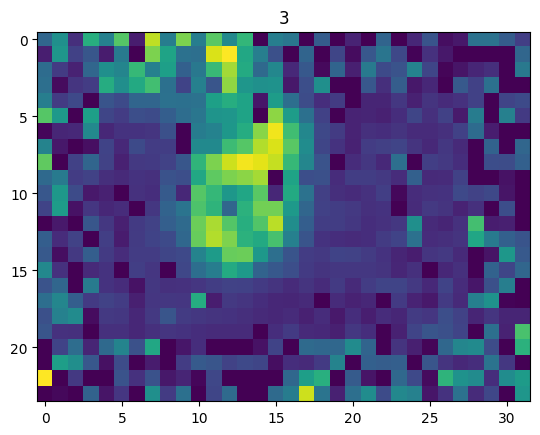

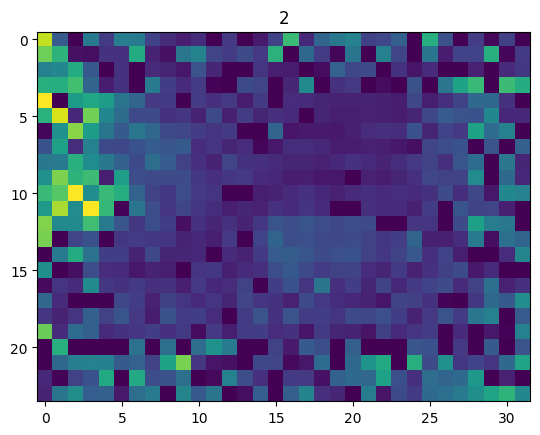

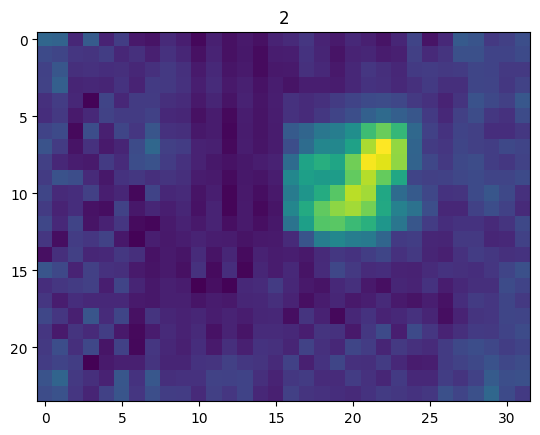

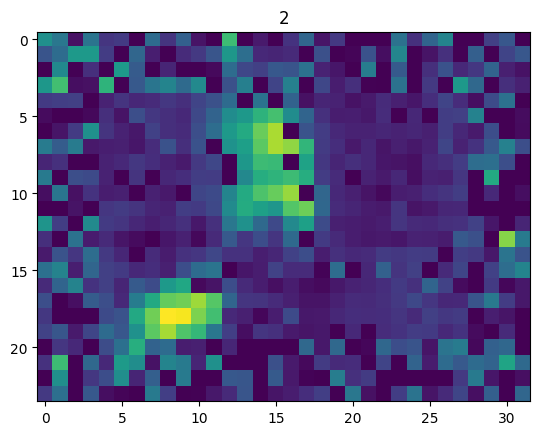

In [12]:
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy())
    plt.title(str(labels[0].numpy().argmax()))
    plt.show()

InputLayer 			(None, 24, 32, 1)

UpSampling2D		(None, 72, 96, 1)

----------------------block 1---------------------------

Conv2D 				(None, 72, 96, 3)

BatchNormalization	(None, 72, 96, 3)

ELU					(None, 72, 96, 3)

ZeroPadding2D		(None, 73, 97, 3)

Conv2D				(None, 36, 48, 1)

BatchNormalization	(None, 36, 48, 1) 		block_1_project_BN

<br/>
<br/>

----------------------block 2---------------------------

Conv2D				(None, 36, 48, 3)

BatchNormalization	(None, 36, 48, 3)

ELU					(None, 36, 48, 3)

Conv2D				(None, 36, 48, 1)

BatchNormalization	(None, 36, 48, 1)		block_2_project_BN

Add	(OutPut-1)		(None, 36, 48, 1)		block_1_project_BN + block_2_project_BN 

<br/>
<br/>

----------------------block 3---------------------------

Conv2D				(None, 36, 48, 3)

BatchNormalization	(None, 36, 48, 3)

ELU					(None, 36, 48, 3)

ZeroPadding2D		(None, 37, 49, 3)

Conv2D				(None, 18, 24, 1)

BatchNormalization	(None, 18, 24, 1)		block_3_project_BN

<br/>
<br/>

----------------------block 4---------------------------

Conv2D				(None, 18, 24, 3)

BatchNormalization	(None, 18, 24, 3)

ELU					(None, 18, 24, 3)

Conv2D				(None, 18, 24, 1)

BatchNormalization	(None, 18, 24, 1)		block_4_project_BN

Add	(OutPut-2)		(None, 18, 24, 1)		block_3_project_BN + block_4_project_BN 

<br/>
<br/>

----------------------block 5---------------------------

Conv2D				(None, 18, 24, 3)

BatchNormalization	(None, 18, 24, 3)

ELU					(None, 18, 24, 3)

ZeroPadding2D		(None, 19, 25, 3)

Conv2D				(None, 9, 12, 1)

BatchNormalization	(None, 9, 12, 1)		block_5_project_BN


In [13]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate, ZeroPadding2D
from keras.models import Model
from keras.layers import Concatenate, MaxPooling2D
from keras.models import Model
from keras.layers import Multiply
from keras.layers import MultiHeadAttention


from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, UpSampling2D, GlobalAveragePooling2D

from keras.layers import ZeroPadding2D
from keras.regularizers import l2
from keras.metrics import Precision, Recall
from keras.layers import Conv2D, MaxPooling2D, concatenate, Add, Lambda
from tensorflow import repeat

class BackBone:
    def __init__(self):
        self.l2_regularizer = l2(0.001)

    def residual_layer(self, feature_map, latent, name:str):
        add_layer = Add(name = name+'_output')([feature_map, latent])
        return add_layer

    def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = Dropout(0.3)(feature_map)

        feature_map = ZeroPadding2D(padding=((0, 1), (0, 1)), name=name+'_pad')(feature_map)
        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'valid', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        return feature_map

    def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        latent =  BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        feature_map = Dropout(0.3)(feature_map)

        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(latent)
        latent = BatchNormalization()(latent)
        residual_block = self.residual_layer(feature_map, latent, name)
        return residual_block


    def __call__(self, input_shape=(24, 32, 1)):
        inputs_image = Input(shape=input_shape)
        # upsample_layer = Conv2DTranspose(filters = 6, kernel_size = 3, strides = (3, 3), padding = 'same')(inputs_image)
        block_1 = self.feature_extraction_block(inputs_image, 16, 32,'block_1')
        block_1_output = self.convolutional_residual_block(block_1, 16, 32,'block_2') # 12, 16
        block_2 = self.feature_extraction_block(block_1_output, 16, 32, 'block_3')
        block_2_output = self.convolutional_residual_block(block_2, 16, 32, 'block_4') # 6, 8
        block_3 = self.feature_extraction_block(block_2_output, 16, 32, 'block_5')
        block_3_output = self.feature_extraction_block(block_3, 16, 32,'block_6') # 3, 4
        # latent = Flatten()(block_3_output)
        # latent = Dense(64, activation='relu', dtype='float32')(latent)
        # latent = Dropout(0.2)(latent)
        # number_output = Dense(5, activation='softmax', name='number_output', dtype='float32')(latent)
        latent = GlobalAveragePooling2D()(block_3_output)
        number_output = Dense(5, activation='softmax', name='number_output', dtype='float32')(latent)

        model = Model(inputs_image, number_output)
        return model

In [14]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

backbone = BackBone()
model = backbone()

initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1)

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     backbone = BackBone()
#     model = backbone()
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', Precision(), Recall()])
#     checkpoint = ModelCheckpoint('v4_backbone_1_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', Precision(), Recall()])

checkpoint = ModelCheckpoint('Classification/Model/model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 block_1 (Conv2D)            (None, 24, 32, 16)           160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 24, 32, 16)           64        ['block_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 24, 32, 16)           0         ['batch_normalization[0][0

In [15]:
# from keras.utils import plot_model

# plot_model(model, to_file='./detection_model.png', show_shapes=True, show_layer_names=True)
# Image(filename='detection_model.png')

In [16]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = DIR
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [17]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=N_EPOCH,
    verbose=1,  
    callbacks=[checkpoint, tensorboard_callback]
    # callbacks=[checkpoint, lr_reducer]
)

# tensorboard --logdir=Classification/Tensorboard --bind_all

Epoch 1/130


2024-02-02 05:47:12.520088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-02 05:47:14.229026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-02-02 05:47:15.186144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-02 05:47:15.190220: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5d267970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-02 05:47:15.190265: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-02 05:47:15.190281: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor

2324/2324 [==============================] - ETA: 0s - loss: 1.2472 - accuracy: 0.5908 - precision: 0.6610 - recall: 0.4598
Epoch 1: val_accuracy improved from -inf to 0.58348, saving model to Classification/Model/model.h5
2324/2324 [==============================] - 57s 21ms/step - loss: 1.2472 - accuracy: 0.5908 - precision: 0.6610 - recall: 0.4598 - val_loss: 1.0889 - val_accuracy: 0.5835 - val_precision: 0.5935 - val_recall: 0.5586
Epoch 2/130
2322/2324 [============================>.] - ETA: 0s - loss: 0.9418 - accuracy: 0.6869 - precision: 0.7076 - recall: 0.6390
Epoch 2: val_accuracy improved from 0.58348 to 0.72609, saving model to Classification/Model/model.h5
2324/2324 [==============================] - 47s 20ms/step - loss: 0.9417 - accuracy: 0.6870 - precision: 0.7077 - recall: 0.6390 - val_loss: 0.8060 - val_accuracy: 0.7261 - val_precision: 0.7397 - val_recall: 0.7045
Epoch 3/130
2323/2324 [============================>.] - ETA: 0s - loss: 0.8343 - accuracy: 0.7152 - prec

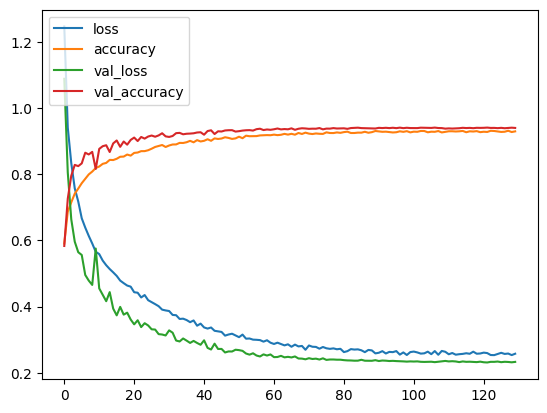

In [18]:
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')

plt.savefig('classification.png')

In [19]:
# model2.save('./v3_3().h5')

In [29]:
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep

# train_dataset, train_number_labels,

# 초기 모델 로드
model = tf.keras.models.load_model('Classification/Model/model.h5')

# 프루닝 설정
epochs = 130
batch_size = 8
num_train_samples = sum(1 for _ in train_ds)
end_step = np.ceil(num_train_samples / batch_size).astype(np.int32) * epochs
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.10,
                                                 final_sparsity=0.30,
                                                 begin_step=0,
                                                 end_step=end_step)
}

# 모델에 프루닝 래퍼 적용
model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)

# 프루닝 모델 컴파일 및 훈련
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.categorical_crossentropy,
                          metrics=['accuracy'])

callbacks = [
    UpdatePruningStep()
]

model_for_pruning.fit(val_ds, epochs=epochs, callbacks=callbacks)

# 프루닝 제거 및 최종 모델 저장
final_model = sparsity.strip_pruning(model_for_pruning)
final_model.save('Classification/Model/pruned_model.h5')


Epoch 1/130


2024-02-02 10:31:15.328231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/prune_low_magnitude_dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


996/996 [==============================] - 38s 26ms/step - loss: 0.6730 - accuracy: 0.7545
Epoch 2/130
996/996 [==============================] - 26s 26ms/step - loss: 0.6410 - accuracy: 0.7705
Epoch 3/130
996/996 [==============================] - 27s 27ms/step - loss: 0.6232 - accuracy: 0.7951
Epoch 4/130
996/996 [==============================] - 26s 26ms/step - loss: 0.6348 - accuracy: 0.7899
Epoch 5/130
996/996 [==============================] - 26s 26ms/step - loss: 0.6313 - accuracy: 0.8043
Epoch 6/130
996/996 [==============================] - 28s 28ms/step - loss: 0.6256 - accuracy: 0.8044
Epoch 7/130
996/996 [==============================] - 27s 27ms/step - loss: 0.6395 - accuracy: 0.8020
Epoch 8/130
996/996 [==============================] - 27s 27ms/step - loss: 0.6251 - accuracy: 0.8106
Epoch 9/130
996/996 [==============================] - 27s 27ms/step - loss: 0.6208 - accuracy: 0.8147
Epoch 10/130
996/996 [==============================] - 26s 26ms/step - loss: 0.6312 

In [30]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 block_1 (Conv2D)            (None, 24, 32, 16)           160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 24, 32, 16)           64        ['block_1[1][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 24, 32, 16)           0         ['batch_normalization[1][0

In [26]:
batch_size = 1
# train_dataset_tf = tf.data.Dataset.from_tensor_slices(test_dataset)
# train_dataset을 배치로 만듦
# batched_train_dataset = train_dataset_tf.batch(batch_size)

In [27]:
import tensorflow as tf

# 기존 모델 로드
model = tf.keras.models.load_model('Classification/Model/pruned_model.h5')

# 대표 데이터셋을 준비하는 함수
def representative_data_gen():
    for input_value, _ in val_ds:  # val_ds의 각 요소는 (data, label) 튜플
        # data 부분만 추출하고 float32 타입으로 캐스팅
        yield [tf.cast(input_value, tf.float32).numpy()]

# 훈련 데이터셋을 로드하고 배치 처리
# 여기서 val_ds는 이미 tf.data.Dataset 형식이고, batch_size는 적절한 값으로 설정해야 합니다.
batched_train_dataset = val_ds.batch(batch_size)
batched_train_dataset = batched_train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), y))  # x는 입력 데이터, y는 레이블

# TFLite 변환기 설정
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 모든 연산을 float32로 제한
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# 입력과 출력을 float32로 설정
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# 모델을 TFLite 모델로 변환
tflite_quant_model = converter.convert()

# TFLite 모델 저장
with open('Classification/Model/quantized_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmp86ecj41k/assets


INFO:tensorflow:Assets written to: /tmp/tmp86ecj41k/assets
2024-02-02 08:33:19.840947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-02 08:33:19.840982: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-02 08:33:19.841174: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp86ecj41k
2024-02-02 08:33:19.848840: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-02 08:33:19.848861: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp86ecj41k
2024-02-02 08:33:19.869160: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-02 08:33:19.978881: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp86ecj41k
2024-02-02 08:33:20.018238: I tensorflow/cc/saved_model/loader.cc:314] SavedModel